In [1]:
# diffuse_test.ipynb
# Authors: Stephan Meighen-Berger
# Tests if another diffuse background model works better

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import csv
# import time

In [3]:
# picture path
PICS = '../pics/'

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=1.
mark_s = 10
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [6]:
# Constants
minutes = 60.
days = 60. * 24

In [7]:
def ice_parser(filename):
    store = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row_num, row in enumerate(reader):
            if row_num == 0:
                continue
            store.append(row[0].split())
    store = np.array(store, dtype=float)
    return store

In [8]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
data_sets = [
    '../data/icecube_10year_ps/events/IC40_exp.csv',
    '../data/icecube_10year_ps/events/IC59_exp.csv',
    '../data/icecube_10year_ps/events/IC79_exp.csv',
    '../data/icecube_10year_ps/events/IC86_I_exp.csv',
    '../data/icecube_10year_ps/events/IC86_II_exp.csv',
    '../data/icecube_10year_ps/events/IC86_III_exp.csv',
    '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/events/IC86_V_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
]
event_dic = {
    0: ice_parser(data_sets[0]),
    1: ice_parser(data_sets[1]),
    2: ice_parser(data_sets[2]),
    3: ice_parser(data_sets[3]),
    4: ice_parser(data_sets[4]),
    5: ice_parser(data_sets[5]),
    6: ice_parser(data_sets[6]),
    7: ice_parser(data_sets[7]),
    8: ice_parser(data_sets[8]),
    9: ice_parser(data_sets[9]),
}

In [9]:
def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic

In [21]:
filtered_data = data_filter(event_dic, [5., 9.], [0., 90.], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
# Construct weighted events
def reshape_events(event_dic, years):
    weighted_data = []
    for year in years:
        weighted_data.append(np.array([
            event_dic[year][:, 1],
            event_dic[year][:, 3],
            event_dic[year][:, 4],
        ]))
        weighted_data[-1] = weighted_data[-1].T
    return np.concatenate([weighted_data[year] for year in years])
test_set = reshape_events(filtered_data, range(10))

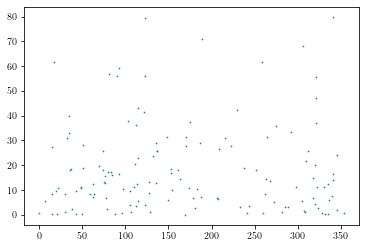

In [23]:
plt.scatter(test_set[:, 1], test_set[:, 2], s=0.5)

In [28]:
# The sky grid
minimal_resolution = 10.
ra_grid = np.arange(0., 360., minimal_resolution)
decl_grid = np.arange(0., 90., minimal_resolution)
ra_bin_len = len(ra_grid) - 1
dec_bin_len = len(decl_grid) - 1
binning_grid = np.linspace(5., 6., 21)

In [29]:
# Binning function
def binning_function_v3(
    test_set, ra_grid, decl_grid, binning_grid=np.linspace(5., 7., 21)
    ):
    ra_ids = np.digitize(test_set[:, 1], ra_grid)
    dec_ids = np.digitize(test_set[:, 2], decl_grid)
    # Pre-filling dic
    binned_events = {}
    unbinned_events = {}
    for ra_id in range(len(ra_ids) - 1):
        for dec_id in range(len(dec_ids) - 1):
            unbinned_events[(ra_id, dec_id)] = []
    for event_id, event in enumerate(test_set):
        unbinned_events[(ra_ids[event_id], dec_ids[event_id])].append(event[0])
    # Binning the angle bins in energy
    for key in unbinned_events.keys():
        binned_events[key], bins = (
            np.histogram(
                unbinned_events[key], bins=binning_grid
            )
        )
    return binned_events, bins
binned_angles, e_bins = binning_function_v3(
    test_set, ra_grid, decl_grid, binning_grid=binning_grid
)

In [30]:
# Diffuse
diffuse_all = np.array([
    binned_angles[key] for key in binned_angles.keys()
])
diffuse_mean = np.mean(diffuse_all, axis=0)
diffuse_sd = np.std(diffuse_all, axis=0)

(5.0, 6.0)

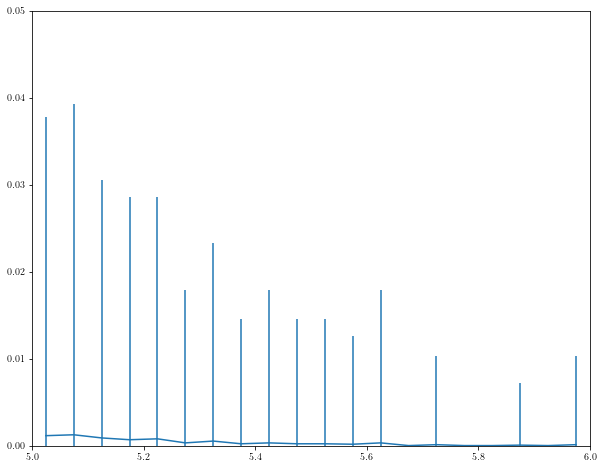

In [32]:
fig = plt.figure(figsize=(10, 8))
plt.errorbar(e_bins[:-1] + np.diff(e_bins) / 2, diffuse_mean, diffuse_sd)
plt.ylim(0., 0.05)
plt.xlim(5., 6.)